In [9]:
import sys

sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano")
%load_ext autoreload
%autoreload 2
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from IPython import display
from PIL import Image
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from tqdm import tqdm

from generate_cow_renders import generate_cow_renders
from plot_image_grid import image_grid

from helpers import *
from nerf import *

from data_io import neuman_helper

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the data
# Datasets
from torch.utils.data import DataLoader
import dataset_from_files
import glob

import smplx
import torch
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
PointLights,
DirectionalLights,
PerspectiveCameras,
Materials,
SoftPhongShader,
RasterizationSettings,
MeshRenderer,
MeshRendererWithFragments,
MeshRasterizer,
TexturesVertex)
from pytorch3d.transforms.so3 import so3_exponential_map, so3_log_map
import matplotlib.pyplot as plt
import mano_pytorch3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_path = '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03'
all_ids = list(range(len(glob.glob(os.path.join(data_path, 'cameras', '*.json')))))

# use 80% of the data for training, randomize the order
np.random.shuffle(all_ids)
train_ids = all_ids[:int(0.6 * len(all_ids))]
test_ids = all_ids[int(0.6 * len(all_ids)):]
print(test_ids)

train_dataset = dataset_from_files.NeumanDataset(data_path, train_ids)
test_dataset = dataset_from_files.NeumanDataset(data_path, test_ids)
full_dataset = dataset_from_files.NeumanDataset(data_path, all_ids)

# We sample 6 random cameras in a minibatch.
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# print example batch
example = next(iter(train_loader))
example

[9, 47, 24, 20, 0, 3, 17, 13, 28, 49, 29, 14, 27, 7, 15, 54, 31, 32, 35, 30, 56, 25, 6, 41]
Fix shapedirs bug of MANO
Fix shapedirs bug of MANO
Fix shapedirs bug of MANO


[{'R_pytorch3d': tensor([[[ 0.6633,  0.2828,  0.6929],
           [-0.0644,  0.9440, -0.3237],
           [-0.7456,  0.1700,  0.6444]]]),
  't_pytorch3d': tensor([[ 0.7742, -0.1910,  0.3783]]),
  'intrinsic_mat': tensor([[[1.2653e+03, 0.0000e+00, 1.9899e+02],
           [0.0000e+00, 1.2658e+03, 2.2659e+02],
           [0.0000e+00, 0.0000e+00, 1.0000e+00]]]),
  'image_size': tensor([[512., 334.]]),
  'focal': tensor([[1265.3059, 1265.8390]]),
  'princpt': tensor([[198.9914, 226.5860]]),
  'campos': tensor([[ 0.7216, -0.3526,  0.3659]]),
  'camrot': tensor([[[ 0.6633, -0.0644,  0.7456],
           [ 0.2828,  0.9440, -0.1700],
           [-0.6929,  0.3237,  0.6444]]])},
 tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0.

In [25]:
def render_mesh(mesh, face, cameras):
    batch_size, vertex_num = mesh.shape[:2]

    textures = TexturesVertex(verts_features=torch.ones((batch_size,vertex_num,3)).float().cuda())
    mesh = Meshes(mesh, face, textures)

    img_size = (512, 334)
    raster_settings = RasterizationSettings(image_size=img_size, blur_radius=0.0, faces_per_pixel=1, perspective_correct=True)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings).cuda()
    lights = PointLights(device='cuda')
    shader = SoftPhongShader(device='cuda', cameras=cameras, lights=lights)
    materials = Materials(
	device='cuda',
        specular_color=((0.0, 1.0, 0.0),),
	shininess=0
    )

    # render
    with torch.no_grad():
        renderer = MeshRendererWithFragments(rasterizer=rasterizer, shader=shader)
        images, fragments = renderer(mesh, materials=materials)
        images = images[:,:,:,:3] * 255
        depthmaps = fragments.zbuf

    return images, depthmaps

hand_model = mano_pytorch3d.MANOCustom(
    model_path='/home/azhuavlev/Desktop/Data/models/mano/MANO_LEFT.pkl',
    is_rhand=False,
    use_pca=False,
)

In [140]:
import mano_pytorch3d

# verts = example[3]['verts'].cuda()
camera_params, images, silhouettes, manos = example

verts_orig = hand_model.forward(
    betas=manos['shape'],
    global_orient=manos['root_pose'],
    hand_pose=manos['hand_pose'],
    transl=manos['trans'],
).vertices.cuda()

faces = torch.from_numpy(hand_model.faces.astype(np.int32)).cuda()[None,:,:]

# R_mat = camera_params['R_pytorch3d']
# T_mat = camera_params['t_pytorch3d']

campos = camera_params['campos']
camrot = camera_params['camrot']

# x_ind = 0
# y_ind = 0
# z_ind = 0
# x_sign = 1
# y_sign = 1
# z_sign = 1
# verts_projected = np.dot(R_mat[0], verts[0].transpose(1,0)).transpose(1,0) + t_mat.reshape(1,3).numpy()

save_dir = '/itet-stor/azhuavlev/net_scratch/Projects/Results/neuman_custom/camera_brute_force/'
curr_iter = -1
for x_ind in [0, 1, 2]:
    break
    for y_ind in [0, 1, 2]:
        for z_ind in [0, 1, 2]:
            for x_sign in [-1, 1]:
                for y_sign in [-1, 1]:
                    for z_sign in [-1, 1]:
                        curr_iter += 1

                        R_mat = camrot.clone()
                        t_mat = -np.dot(R_mat, campos.reshape(3, 1)).reshape(3)  # -Rt -> t
                        t_mat = torch.from_numpy(t_mat).float().unsqueeze(0)

                        R_mat = R_mat.clone().squeeze(0).cuda().transpose(0,1)
                        R_mat = torch.stack((
                            x_sign * R_mat[x_ind],
                            y_sign * R_mat[y_ind],
                            z_sign * R_mat[z_ind]
                        ), 0)
                        R_mat = R_mat.unsqueeze(0)

                        t_mat = t_mat.squeeze(0).cuda()
                        t_mat = torch.stack((
                            x_sign * t_mat[x_ind],
                            y_sign * t_mat[y_ind],
                            z_sign * t_mat[z_ind]
                        ), 0)
                        t_mat = t_mat.unsqueeze(0)

                        verts = verts_orig.clone().squeeze(0)
                        verts = torch.stack((
                            x_sign * verts[:, x_ind],
                            y_sign * verts[:, y_ind],
                            z_sign * verts[:, z_ind]
                        ),1)
                        verts = verts.unsqueeze(0)

                        camera = PerspectiveCameras(
                            R=R_mat,
                            T=T_mat,
                            focal_length=camera_params['focal'],
                            principal_point=camera_params['princpt'],
                            in_ndc=False,
                            image_size=camera_params['image_size'],
                            device='cuda'
                        )
                        # %matplotlib inline

                        # from pytorch3d.utils.camera_conversions import cameras_from_opencv_projection
                        # camera = cameras_from_opencv_projection(
                        #     R_mat,
                        #     t_mat,
                        #     camera_params['intrinsic_mat'],
                        #     camera_params['image_size'],
                        # )
                        camera = camera.to(device)
                        # verts = torch.stack((verts[:,:,0], verts[:,:,1], verts[:,:,2]),2)

                        img, depth = render_mesh(verts, faces, camera)

                        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

                        ax[0].imshow(img[0].cpu().numpy().astype(np.uint8))
                        ax[1].imshow(images[0].cpu().numpy())

                        fig.savefig(save_dir + f'{x_ind}{y_ind}{z_ind}{x_sign}{y_sign}{z_sign}.png')
                        plt.close(fig)
                        print(curr_iter)

In [146]:
verts_xyz = hand_model.forward(
    betas=manos['shape'],
    global_orient=manos['root_pose'],
    hand_pose=manos['hand_pose'],
    transl=manos['trans'],
).vertices
print(campos.shape)
%matplotlib notebook

campos = camera_params['campos']/1000000
print(camera_params['campos'])

# plot the vertices as 3d points
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

print(R_mat.shape, t_mat.shape, verts_xyz.shape)

# plot vertices as matplotlib mesh
# verts_projected = np.dot(R_mat[0], verts_xyz[0].transpose(1,0)).transpose(1,0) + t_mat.reshape(1,3).numpy()

# ax.scatter(verts_projected[0, :, 0], verts_projected[0, :, 1], verts_projected[0, :, 2], s=2)

# verts_xyz *= 1000
ax.scatter(verts_xyz[0,:, 0], verts_xyz[0,:, 1], verts_xyz[0,:, 2], s=2)

# campos *= 1000
ax.scatter(-campos[0, 0], -campos[0, 1], campos[0, 2], s=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

torch.Size([1, 3])
tensor([[ 721591.0000, -352593.9375,  365920.2812]])


<IPython.core.display.Javascript object>

torch.Size([1, 3, 3]) torch.Size([1, 3]) torch.Size([1, 778, 3])


[[1.2653059e+03 0.0000000e+00 1.9899142e+02]
 [0.0000000e+00 1.2658390e+03 2.2658598e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
(778, 3) (3, 3) (1, 3) (3, 3)
float32 float32 float32 float32
torch.Size([1, 3, 3])


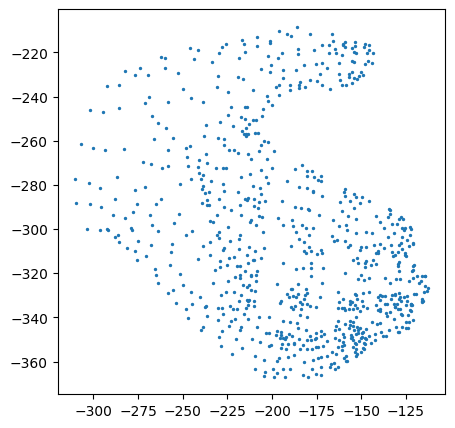

In [91]:
import cv2 as cv
print(camera_params['intrinsic_mat'][0].numpy())
print(verts_xyz[0].numpy().shape, R_mat[0].numpy().shape, t_mat.numpy().shape, camera_params['intrinsic_mat'][0].numpy().shape)
print(verts_xyz[0].numpy().dtype, R_mat[0].numpy().dtype, t_mat.numpy().dtype, camera_params['intrinsic_mat'][0].numpy().dtype)

from pytorch3d.transforms.so3 import so3_exponential_map, so3_log_map
print(R_mat.shape)
rot_vec = so3_log_map(R_mat)


imagePoints = cv.projectPoints(verts_xyz[0].numpy(), rot_vec[0].numpy(), t_mat.numpy(), camera_params['intrinsic_mat'][0].numpy(), np.zeros(4, dtype=np.float32))[0]

# plot image points
%matplotlib inline
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.scatter(-imagePoints[:, 0, 0], -imagePoints[:, 0, 1], s=2)
